<a href="https://colab.research.google.com/github/Ping-YUAN/heartbeat-analysis-ai/blob/DataViz_MIT_Sepideh/Heartbeat_DataViz_MIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import the necessary packages and define the paths:**

In [10]:
# Install necessary libraries quietly
# !pip install tensorflow -q
# !pip install keras -q
# !pip install scikit-learn -q
# !pip install pandas -q
# !pip install numpy -q
# !pip install matplotlib -q
!pip install umap-learn


# Verify installation and import libraries
# import tensorflow as tf
# import keras
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

# Mount Google Drive in Colab if I want to upload the dataset from Google Drive:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Heartbeat_Project

# remove the sample_data directory and all of its contents
!rm -rf /content/sample_data

# Path = dict({
#     'mitbih_test': '../data/raw/mitbih_test.csv',
#     'mitbih_train': '../data/raw/mitbih_train.csv',
# })

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Heartbeat_Project


# **Define the necessary functions:**

In [11]:
def addColumnsToDataframe(df):
    """
    As the dataset is composed with 188 columns with the 188th columns as the category values,
    so we give the last column the name 'target', others named with 'c_0 to c_186'
    """
    num_columns= df.shape[1]
    feature_col_name = ['c_' + str(i) for i in range(0, num_columns - 1)]
    df_columns = feature_col_name + ['target']
    df.columns = df_columns
    return df

def convertColumnAsInt(df, column):
    """
    As the category value is in float type. We want to get the int to identify the category.
    """
    df[column] = df[column].astype(int)
    return df


def getBarChartFromCategoryValueCounts(category_value_counts):
    """
    We call the plot over the pandas series object to plot the category count values
    """

    # Sample data
    categories = category_value_counts.index
    values = category_value_counts.values
    colors = ['green', 'gray', 'red', 'yellow', 'orange']  # Replace with desired colors
    labels = ['Normal', 'Unclassified','Venticular', 'Supraventicular', 'Fusion']  # Replace with corresponding labels

    plt.figure(figsize=(8, 5))

    # Plot each bar with a unique color and label
    bars = plt.bar(range(len(categories)), values, color=colors)  # Use range(len(categories)) as x-coordinates

    plt.title('Category Count Values')
    plt.xlabel('Categories')
    plt.ylabel('Count')
    plt.grid(False)

    # Set the custom tick labels
    plt.xticks(range(len(categories)), categories, rotation=360)

    # Add a legend
    plt.legend(bars, labels, title='Legend Title')  # Associate bars with labels

    # Label each bar with its count value
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

    plt.show()

def plot_overlay_ecg_signals(df, label, color):
    # Define a function to plot overlay of ECG signals for a single class from both datasets

    # Extract data rows for the specified class label
    class_data = df[df['target'] == label]

    # Check if there is any data for the specified class label
    if class_data.empty:
        print(f"No data found for class {label}")
        return

    # Extract a sample data row (first row) for the specified class label
    sample_data = class_data.iloc[0]

    # Plot the sample ECG signal, excluding the 'target' column
    plt.plot(sample_data[:-1], label=label, color=color)

def apply_pca_to_dataset(df, n_components=2):

    X = df.drop(columns=['target'])
    y = df['target']

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    # Create a DataFrame with the principal components
    principal_components = [f'Principal Component {i+1}' for i in range(n_components)]
    df_pca = pd.DataFrame(data=X_pca, columns=principal_components)
    df_pca['target'] = y

    return df_pca, pca

def plot_pca_results(df_pca, title='PCA Results'):

    # Convert categorical labels to numerical values
    unique_labels = df_pca['target'].unique()
    label_to_number = {label: number for number, label in enumerate(unique_labels)}
    color_sequence = df_pca['target'].map(label_to_number)

    # Scatter plot of the first two principal components
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(df_pca['Principal Component 1'], df_pca['Principal Component 2'],
                          c=color_sequence, cmap='viridis', alpha=0.5)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

    # Create a colorbar with the correct labels
    cbar = plt.colorbar(scatter, ticks=np.arange(len(unique_labels)))
    cbar.set_label('Class')
    cbar.set_ticklabels(unique_labels)

    plt.show()

def plot_3d_pca(df_pca, title='3D PCA Results'):

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')


    x = df_pca.iloc[:, 0]
    y = df_pca.iloc[:, 1]
    z = df_pca.iloc[:, 2]

    # Convert categorical labels to numerical values for coloring
    unique_labels = df_pca['target'].unique()
    label_to_number = {label: number for number, label in enumerate(unique_labels)}
    colors = df_pca['target'].map(label_to_number)

    scatter = ax.scatter(x, y, z, c=colors, cmap='viridis', depthshade=True)


    cbar = plt.colorbar(scatter, ticks=range(len(unique_labels)))
    cbar.set_label('Class')
    cbar.set_ticklabels(unique_labels)

    ax.set_title(title)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')

    plt.show()

# **Read the CSV files of the MIT-BIH Arrhythmia Dataset:**

In [12]:
# MIT Train
mitbih_train = pd.read_csv('mitbih_train.csv', header=None)
mitbih_train_with_columns = addColumnsToDataframe(mitbih_train)
mitbih_train_with_columns = convertColumnAsInt(mitbih_train_with_columns, 'target')

# MIT Test
mitbih_test = pd.read_csv('mitbih_test.csv', header=None)
mitbih_test_with_columns = addColumnsToDataframe(mitbih_test)
mitbih_test_with_columns = convertColumnAsInt(mitbih_test_with_columns, 'target')

# **First information about both datasets:**

In [13]:
# MIT train Info:

print('The MIT train dataset has', mitbih_train.shape[0], 'rows and', mitbih_train.shape[1], 'columns.\n'
      'Each row represents a single heartbeat, and each column from c-0 to c-186 contains a datapoint for one heartbeat.', '\n'
      'the percentage of missing values is', mitbih_train.isnull().mean().mean() * 100, '\n'
      'Number of rows duplicated :',  mitbih_train.duplicated().sum())

# MIT test Info:
print('\n\nThe MIT test dataset has', mitbih_test.shape[0], 'rows and', mitbih_test.shape[1], 'columns.\n'
      'Each row represents a single heartbeat, and each column from c-0 to c-186 contains a datapoint for one heartbeat.', '\n'
      'the percentage of missing values is', mitbih_test.isnull().mean().mean() * 100, '\n'
      'Number of rows duplicated :',  mitbih_test.duplicated().sum())

print("\n\nThe both datasets have no missing values.")
print("\n\nThe features are numeric. All columns have the type float64, while the target column is int32.")

The MIT train dataset has 87554 rows and 188 columns.
Each row represents a single heartbeat, and each column from c-0 to c-186 contains a datapoint for one heartbeat. 
the percentage of missing values is 0.0 
Number of rows duplicated : 0


The MIT test dataset has 21892 rows and 188 columns.
Each row represents a single heartbeat, and each column from c-0 to c-186 contains a datapoint for one heartbeat. 
the percentage of missing values is 0.0 
Number of rows duplicated : 0


The both datasets have no missing values.


The features are numeric. All columns have the type float64, while the target column is int32.


# **Plot the category count values**

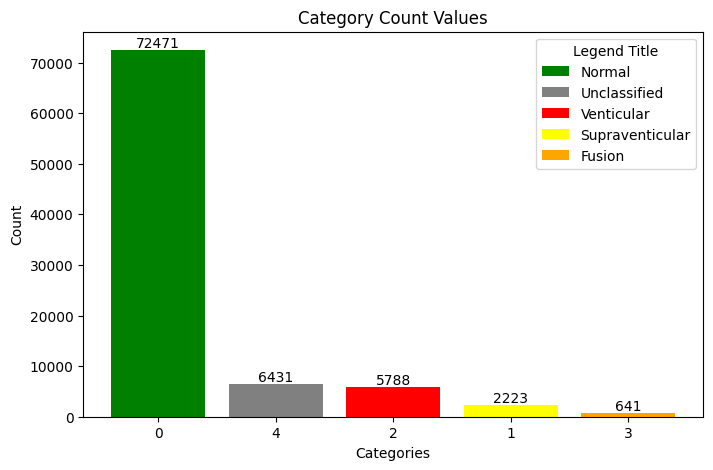

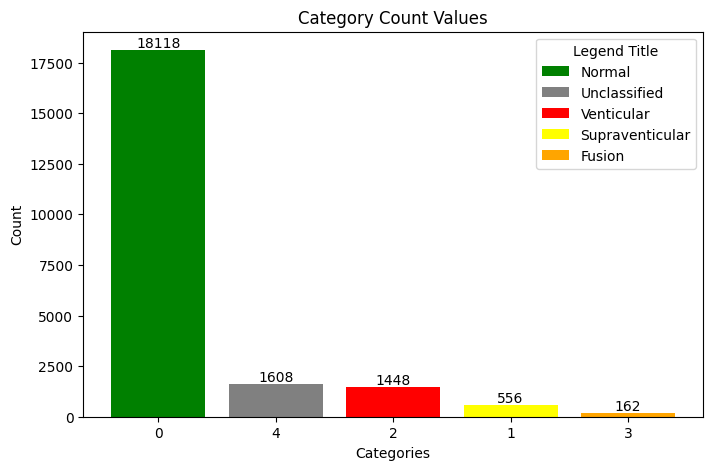

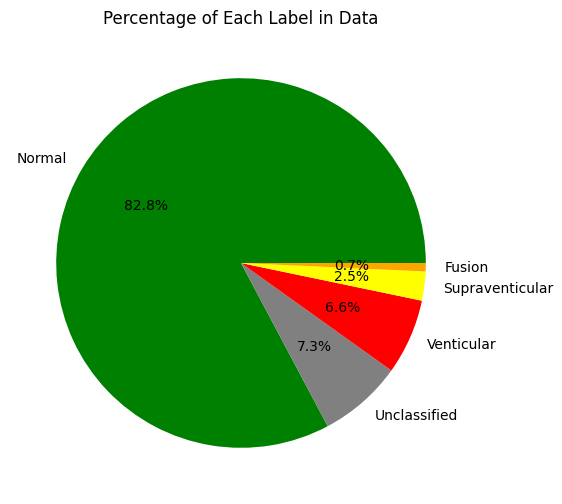

In [14]:
getBarChartFromCategoryValueCounts(mitbih_train_with_columns['target'].value_counts())
getBarChartFromCategoryValueCounts(mitbih_test_with_columns['target'].value_counts())

label_counts = mitbih_train_with_columns['target'].value_counts(normalize=True)
colors = ['green', 'gray', 'red', 'yellow', 'orange']  # Replace with desired colors
labels = ['Normal', 'Unclassified','Venticular', 'Supraventicular', 'Fusion']

# Plot a pie chart
plt.figure(figsize=(10, 6))
plt.pie(label_counts, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title('Percentage of Each Label in Data')
plt.show()


# **Convert target variable to categorical and remove unclassifiable class**

In [15]:
# Define your mapping dictionary
class_mapping = {
    0: 'Normal',
    1: 'Supraventicular',
    2: 'Venticular',
    3: 'Fusion',
    4: 'Unclassifiable'
}

# Convert target variable to categorical in both training and test datasets
mitbih_train['target'] = mitbih_train['target'].map(class_mapping)
mitbih_test['target'] = mitbih_test['target'].map(class_mapping)

# Drop rows where 'target' is 'Unclassifiable beat'
mitbih_train = mitbih_train[mitbih_train['target'] != 'Unclassifiable']
mitbih_test = mitbih_test[mitbih_test['target'] != 'Unclassifiable']

# display(mitbih_train.head())
# display(mitbih_test.head())


# **plot overlay of ECG signals from both datasets for a single class**

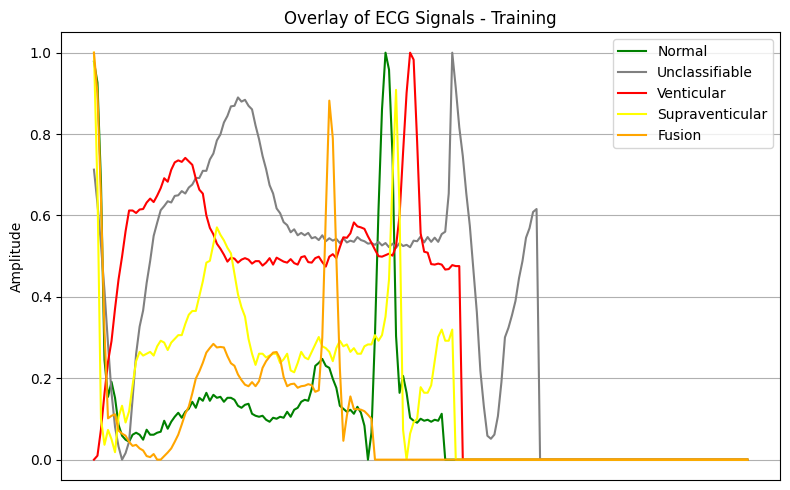

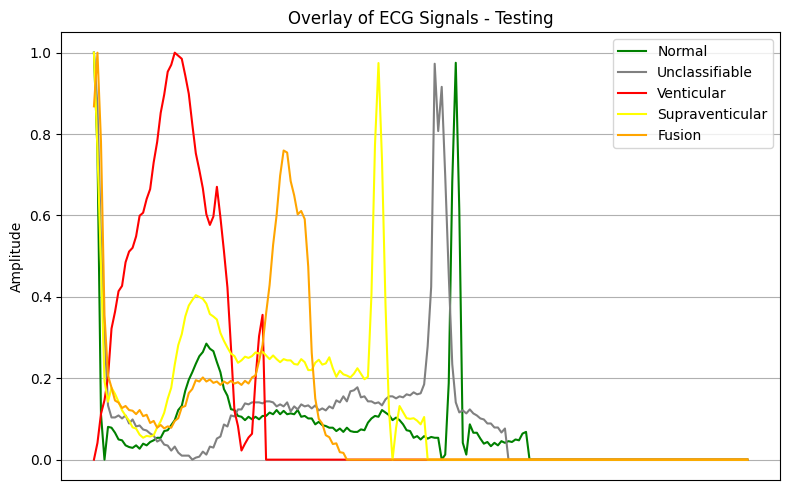

In [16]:
# Colors for each class
colors = ['green', 'gray', 'red', 'yellow', 'orange']

# Labels for each class
labels = ['Normal', 'Unclassifiable','Venticular', 'Supraventicular', 'Fusion']

# Plotting overlay for each class in both datasets
plt.figure(figsize=(8, 5))

# Plotting for training dataset
for label, color in zip(labels, colors):
    plot_overlay_ecg_signals(mitbih_train_with_columns, label, color)

plt.title("Overlay of ECG Signals - Training")
plt.ylabel('Amplitude')
plt.grid(True)
plt.xticks([])  # Remove x-axis ticks and labels
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))

# Plotting for testing dataset
for label, color in zip(labels, colors):
    plot_overlay_ecg_signals(mitbih_test_with_columns, label, color)

plt.title("Overlay of ECG Signals - Testing")
plt.ylabel('Amplitude')
plt.grid(True)
plt.xticks([])  # Remove x-axis ticks and labels
plt.legend()
plt.tight_layout()
plt.show()


# **identify patterns and relationships between different heartbeats within the same class by using Correlation Matrix**

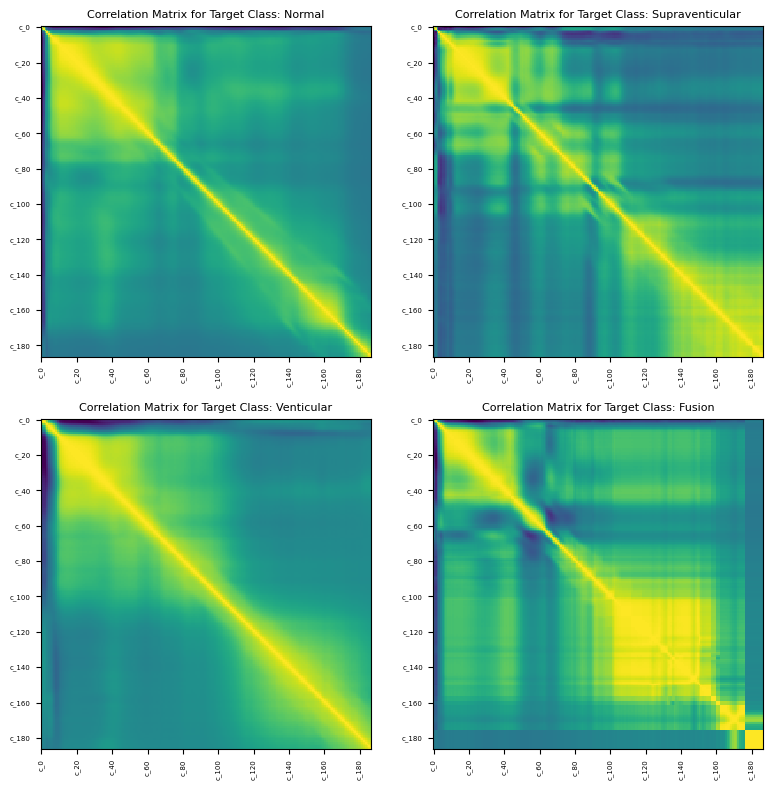

In [17]:

def plotCorrelationMatrixByClass(mitbih_train, target, graphWidth=8, tick_frequency=20):
    # Ensure mitbih_train is a DataFrame and has at least 2 columns
    if not isinstance(mitbih_train, pd.DataFrame) or mitbih_train.shape[1] < 2:
        print(f'Error: Invalid DataFrame provided. Expected at least 2 columns.')
        return

    # Check if target column exists in the DataFrame
    if target not in mitbih_train.columns:
        print(f'Error: Target variable "{target}" not found in DataFrame columns.')
        return

    # Exclude the target variable from the DataFrame
    df_without_target = mitbih_train.drop(columns=[target])

    # Get unique classes of the target variable
    unique_classes = mitbih_train[target].unique()

    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(graphWidth, graphWidth))

    # Flatten the axs array for easy iteration
    axs = axs.flatten()

    # Iterate through unique classes and plot correlation matrix for each
    for i, cls in enumerate(unique_classes):
        # Subset the data for the current class
        df_class = df_without_target[mitbih_train[target] == cls]

        # Drop columns with NaN and keep those with more than 1 unique value
        df_class = df_class.dropna(axis='columns', how='any')
        df_class = df_class[[col for col in df_class if df_class[col].nunique() > 1]]

        # Check if there are enough columns left for correlation calculation
        if df_class.shape[1] < 2:
            print(f'No correlation plots shown for class "{cls}": The number of non-NaN or constant columns ({df_class.shape[1]}) is less than 2')
            continue

        # Calculate correlation matrix
        corr = df_class.corr()

        # Plot the correlation matrix in the current subplot
        axs[i].matshow(corr)

        # Set x and y tick labels every tick_frequency-th label
        axs[i].set_xticks(range(0, len(corr.columns), tick_frequency))
        axs[i].set_xticklabels(corr.columns[::tick_frequency], rotation=90,fontsize=5)
        axs[i].set_yticks(range(0, len(corr.columns), tick_frequency))
        axs[i].set_yticklabels(corr.columns[::tick_frequency],fontsize=5)

        axs[i].xaxis.tick_bottom()
        axs[i].set_title(f'Correlation Matrix for Target Class: {cls}', fontsize=8)

    plt.tight_layout()
    plt.show()

# Example usage with the DataFrame mitbih_train and the target variable 'target'
plotCorrelationMatrixByClass(mitbih_train, target='target', graphWidth=8, tick_frequency=20)


# **Perform Histogram**

4710615
4710615


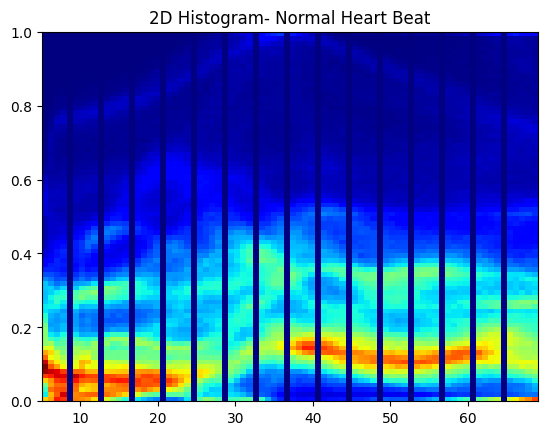

144495
144495


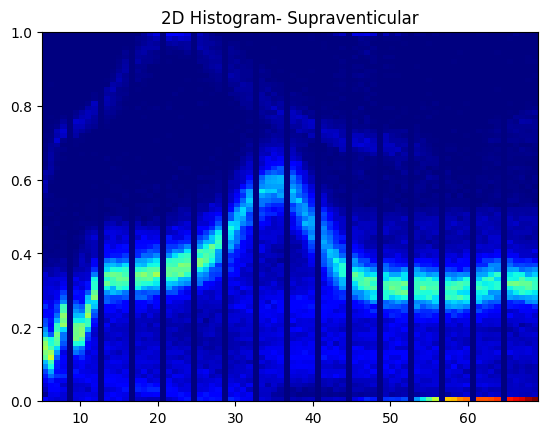

376220
376220


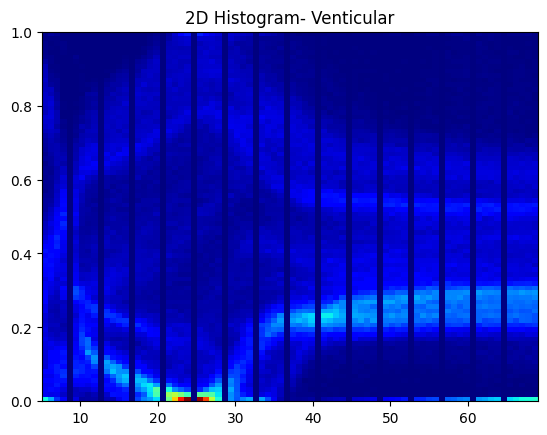

41665
41665


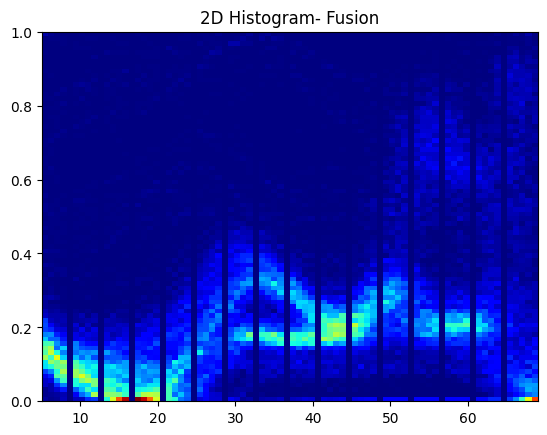

<Figure size 640x480 with 0 Axes>

In [18]:
def plot_hist(class_name, min_val = 5, size = 70, title=''):
    img = mitbih_train.loc[mitbih_train['target']==class_name].values
    img = img[:, min_val: size]
    img_flatten = img.flatten()

    final1 = np.arange(min_val, size)
    for _ in range(img.shape[0]-1):
        tempo1 = np.arange(min_val, size)
        final1 = np.concatenate((final1, tempo1))
    print(len(final1))
    print(len(img_flatten))
    plt.hist2d(final1, img_flatten, bins=(80, 80), cmap=plt.cm.jet)
    plt.title('2D Histogram- '+title)

    plt.show()
    plt.savefig('2D Histogram- '+title+'.PNG')

plot_hist('Normal', title='Normal Heart Beat')
plot_hist('Supraventicular', title='Supraventicular')
plot_hist('Venticular', title='Venticular')
plot_hist('Fusion', title='Fusion')

# **PCA Functions**

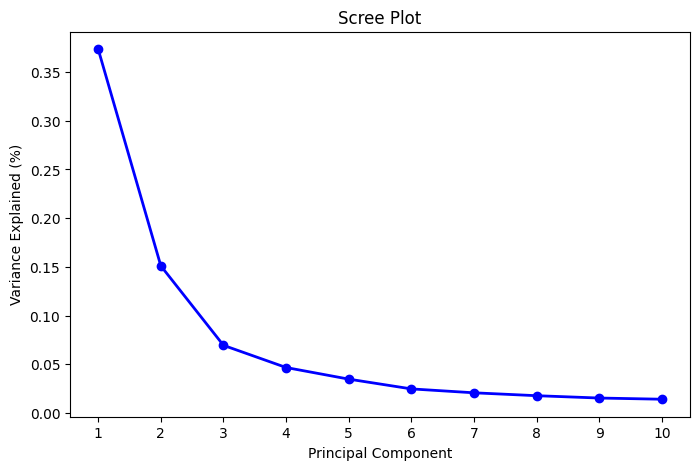

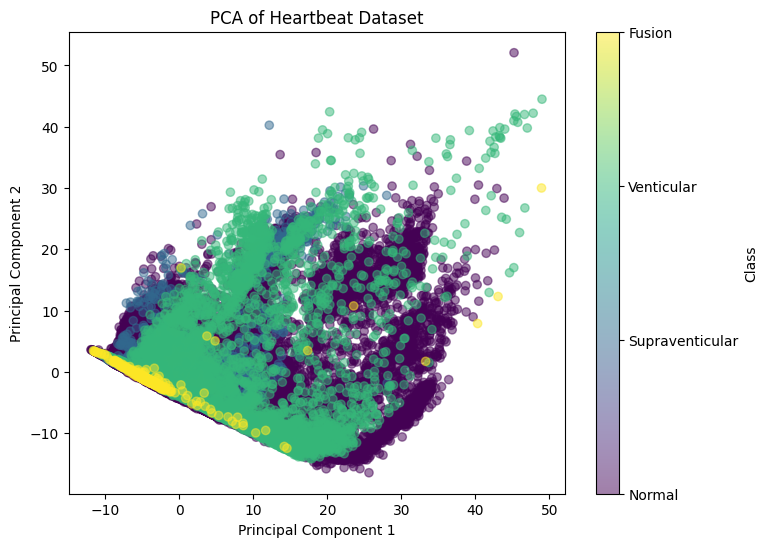

In [19]:
df_pca, pca = apply_pca_to_dataset(mitbih_train, n_components=2)


df_pca, pca = apply_pca_to_dataset(mitbih_train, n_components=10)

def create_scree_plot(pca, title='Scree Plot'):

    explained_var_ratio = pca.explained_variance_ratio_
    components = np.arange(len(explained_var_ratio)) + 1

    plt.figure(figsize=(8, 5))
    plt.plot(components, explained_var_ratio, 'o-', linewidth=2, color='blue')
    plt.title(title)
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained (%)')
    plt.xticks(components)
    plt.show()

create_scree_plot(pca)

#Plot 2D
plot_pca_results(df_pca, title='PCA of Heartbeat Dataset')


# #Plot 3D
# df_pca, pca = apply_pca_to_dataset(mitbih_train, n_components=3)
# plot_3d_pca(df_pca, title='3D PCA of Heartbeat Dataset')

# plot 3D with rotation adjustment
df_pca, pca= apply_pca_to_dataset(mitbih_train, n_components=3)


color_discrete_scale = ['green', 'yellow', 'red', 'blue']

fig = px.scatter_3d(df_pca, x='Principal Component 1', y='Principal Component 2', z='Principal Component 3',
                    color='target',
                    color_discrete_sequence=color_discrete_scale,
                    title='3D PCA of Heartbeat Dataset',
                    labels={'target': 'Class'})
fig.update_traces(marker=dict(size=5))
fig.show()


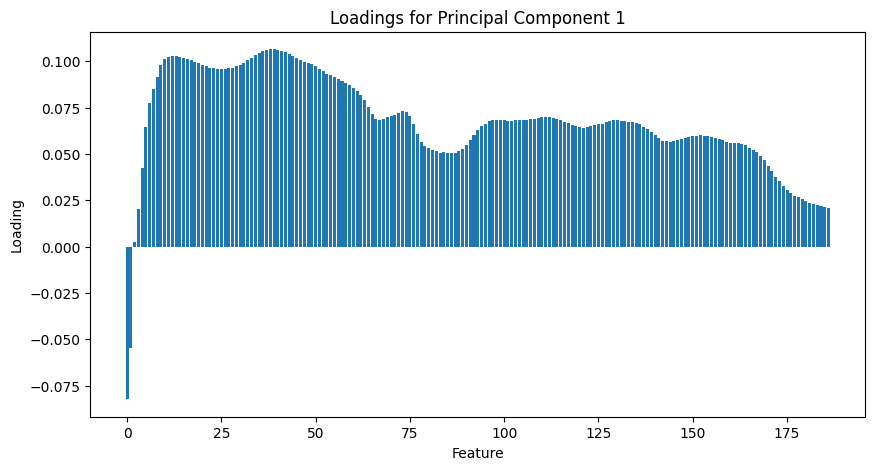

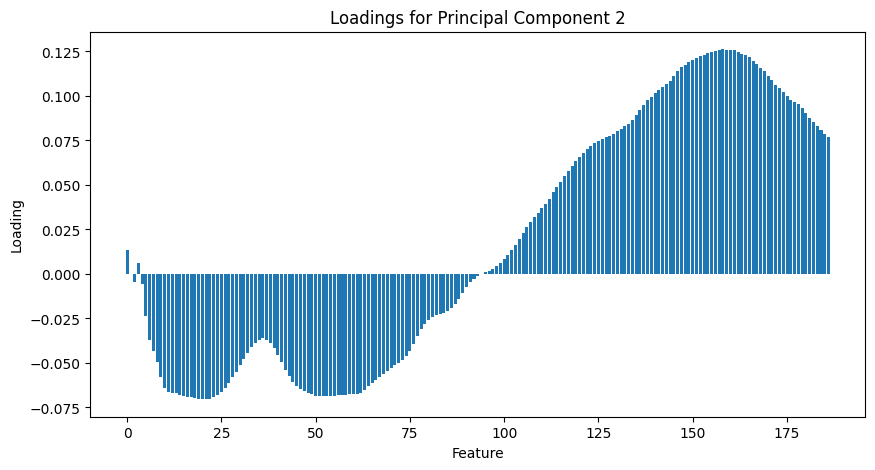

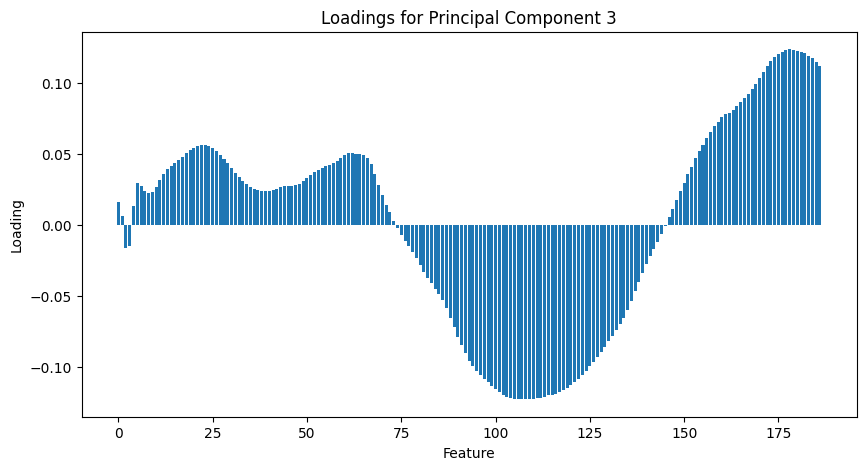

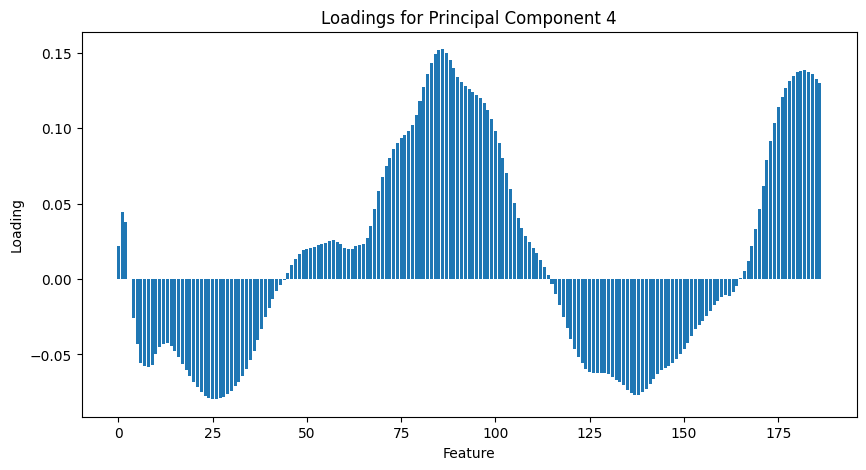

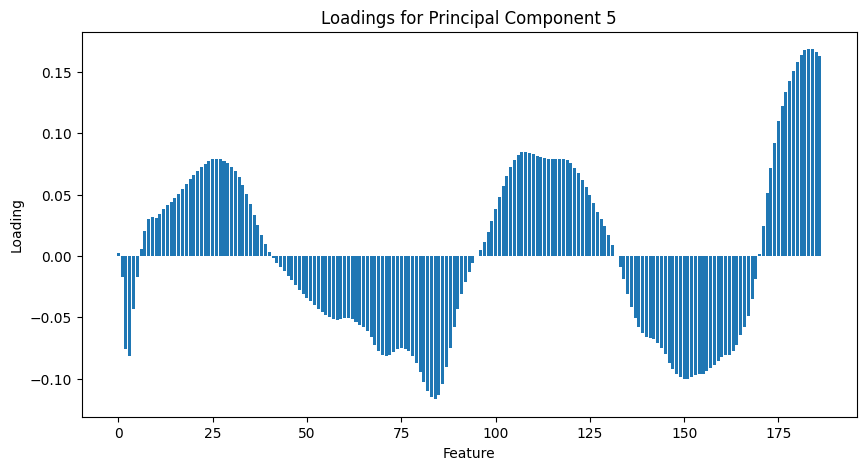

In [20]:
df_pca, pca = apply_pca_to_dataset(mitbih_train, n_components=5)


loadings = pca.components_


for i, component in enumerate(loadings):

    plt.figure(figsize=(10, 5))


    plt.bar(x=range(len(component)), height=component)


    plt.xlabel('Feature')
    plt.ylabel('Loading')
    plt.title(f'Loadings for Principal Component {i+1}')

    plt.show()
# loadings” refers to the weights or coefficients of the original variables in the principal components.
# They indicate how much each feature contributes to each principal component.

# **Identify significant features**

In [21]:
from scipy.stats import f_oneway, kruskal
# Separate features and labels
features = mitbih_train.iloc[:, :-1]
labels = mitbih_train['target']


p_values = []


for i in range(features.shape[1]):

    class_groups = [features[labels == label].iloc[:, i] for label in class_mapping.values()]

    # If normally distributed, use ANOVA
    # f_stat, p_val = f_oneway(*class_groups)

    # If not normally distributed, use Kruskal-Wallis H-test
    h_stat, p_val = kruskal(*class_groups)
    p_values.append(p_val)


adjusted_p_values = [p * len(p_values) for p in p_values]

# Select features with p-value below the significance level
significant_features = [i for i, p_val in enumerate(adjusted_p_values) if p_val < 0.05]

print(f'Number of significant features: {len(significant_features)}')
# print(f'Significant features: {significant_features}')

print('The absence of significant features suggests that the classes may not be well-separated in the original feature space,\n which could make it challenging for PCA and t-SNE to clearly distinguish between them')

Number of significant features: 0
The absence of significant features suggests that the classes may not be well-separated in the original feature space,
 which could make it challenging for PCA and t-SNE to clearly distinguish between them


# **Perform t_SNE**

In [ ]:
from sklearn.manifold import TSNE

# Separate features and labels
features = mitbih_train.iloc[:, :-1]
labels = mitbih_train.iloc[:, -1]

# Reduce dimensionality with PCA
pca = PCA(n_components=50)
features_pca = pca.fit_transform(features)

# Initialize t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)

# Perform t-SNE
tsne_results = tsne.fit_transform(features_pca)

# Plot the results
plt.figure(figsize=(16,10))
unique_labels = df_pca['target'].unique()
label_to_number = {label: number for number, label in enumerate(unique_labels)}
colors = df_pca['target'].map(label_to_number)


scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=colors, cmap='viridis', alpha=0.5)
plt.title('t-SNE visualization of MIT-train dataset')
plt.xlabel('t-SNE axis 1')
plt.ylabel('t-SNE axis 2')
plt.legend(handles=scatter.legend_elements()[0], labels=['Normal', 'Ventricular', 'Supraventricular', 'Fusion'])
plt.show()

# **Perform UMAP**

In [ ]:
from umap import UMAP

features = mitbih_train.drop(columns=['target'])

# Apply UMAP
umap = UMAP(n_components=2, random_state=42)  # Set random_state for reproducibility
df_umap = umap.fit_transform(features)

# Plot the results
plt.figure(figsize=(16,10))
unique_labels = mitbih_train['target'].unique()
label_to_number = {label: number for number, label in enumerate(unique_labels)}
colors = mitbih_train['target'].map(label_to_number)

plt.scatter(df_umap[:, 0], df_umap[:, 1], c=colors, cmap='viridis', alpha=0.5)
plt.title('UMAP visualization of MIT-train dataset')
plt.xlabel('UMAP axis 1')
plt.ylabel('UMAP axis 2')
plt.legend(handles=scatter.legend_elements()[0], labels=['Normal', 'Ventricular', 'Supraventricular', 'Fusion'])
plt.show()



# **Perform ISOMAP**

In [ ]:
# from sklearn.manifold import Isomap

# features = mitbih_train.drop(columns=['target'])
# # Create an isomap and fit the data
# iso = Isomap(n_components=2,n_neighbors=5)
# df_isomap = iso.fit_transform(features)

# # Plot the results
# plt.figure(figsize=(16,10))
# unique_labels = mitbih_train['target'].unique()
# label_to_number = {label: number for number, label in enumerate(unique_labels)}
# colors = mitbih_train['target'].map(label_to_number)

# plt.scatter(df_isomap[:, 0], df_isomap[:, 1], c=colors, cmap='viridis', alpha=0.5)
# plt.title('UMAP visualization of MIT-train dataset')
# plt.xlabel('UMAP axis 1')
# plt.ylabel('UMAP axis 2')
# plt.legend(handles=scatter.legend_elements()[0], labels=['Normal', 'Ventricular', 'Supraventricular', 'Fusion'])
# plt.show()
